In [4]:
!pip install torchdiffeq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [15]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
import math

In [12]:
import torch.nn.functional as F

class SinActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))

        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(self.grid.T[self.spline_order:-self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        x = x.unsqueeze(-1)
        grid = self.grid
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1] +
                     (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1)
        )
        output = base_output + spline_output
        return output.reshape(*original_shape[:-1], self.out_features)


class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for in_f, out_f in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_f, out_f, grid_size, spline_order, scale_noise,
                                         scale_base, scale_spline, True,
                                         base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
!pip install torchdiffeq --quiet

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt

#parameters
L = 5.0
N = 201   # number of spatial points
T = torch.tensor(torch.pi / 2)
nt = 100  # number of time points

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.linspace(-L, L, N, device=device)
dx = x[1] - x[0]  #computes the spatial step size
t = torch.linspace(0, T, nt, device=device)

# 2. Initial Condition
def sech(x): return 1 / torch.cosh(x)
u0_real = sech(x)
u0_imag = torch.zeros_like(x)
u0 = torch.cat([u0_real, u0_imag], dim=0).float() #concatenates the real and imaginary part

# 3. Laplacian (Periodic BC)
def laplacian(u, dx):
    return (torch.roll(u, -1, 0) - 2 * u + torch.roll(u, 1, 0)) / dx**2   #approximation of second order differentiation
#u,-1,0 --> shifts element to left (ui+1)
#u,1,0 --> shifts element to right (ui-1)

# 4. Ground Truth Schrödinger Model
class SchrodingerODE(nn.Module):
    def __init__(self, N):    #self is the current instance of the class
        super().__init__()
        self.N = N    #Stores the number of spatial points, used to split real and imaginary parts

    def forward(self, t, u):  #called by the ODE solve
        real = u[:self.N]
        imag = u[self.N:]
        u_complex = real + 1j * imag #reconstructs the complex valued wavefunction

        lap_u = laplacian(u_complex, dx)
        abs_sq = torch.abs(u_complex)**2
        nonlin = abs_sq * u_complex

        dudt = 1j * (-0.5 * lap_u - nonlin)   #rhs of the schrodinger equation
        return torch.cat([dudt.real, dudt.imag])

# 5. Get Ground Truth Solution
true_model = SchrodingerODE(N).to(device)
with torch.no_grad(): #we're just simulating and not training and hence removing the gradient tracking
    sol_true = odeint(true_model, u0, t, method='dopri5')  # [nt, 2N]   #odeint from torchdiffeq is the ode solver

# 6. KAN-ODE (Surrogate Model using KAN)
class KANODE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.kan = KAN([input_dim, 10, 10, input_dim])  #building the layer as mentioned

    def forward(self, t, u):
        return self.kan(u)

# 7. Train on Sparse Samples
model = KANODE(2 * N).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_indices = torch.linspace(0, nt-1, 8).long() #long is to convert floating point to integers since it is referring to indices
t_train = t[train_indices]
u_train = sol_true[train_indices].detach()
#to train only in those sparse time points

for epoch in range(300):
    optimizer.zero_grad()
    pred = odeint(model, u0, t_train)
    loss = loss_fn(pred, u_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# 8. Evaluate full trajectory from surrogate
with torch.no_grad():
    pred_full = odeint(model, u0, t)



Epoch 0: Loss = 0.025363
Epoch 50: Loss = 0.007639
Epoch 100: Loss = 0.000301
Epoch 150: Loss = 0.000133
Epoch 200: Loss = 0.000126
Epoch 250: Loss = 0.000116


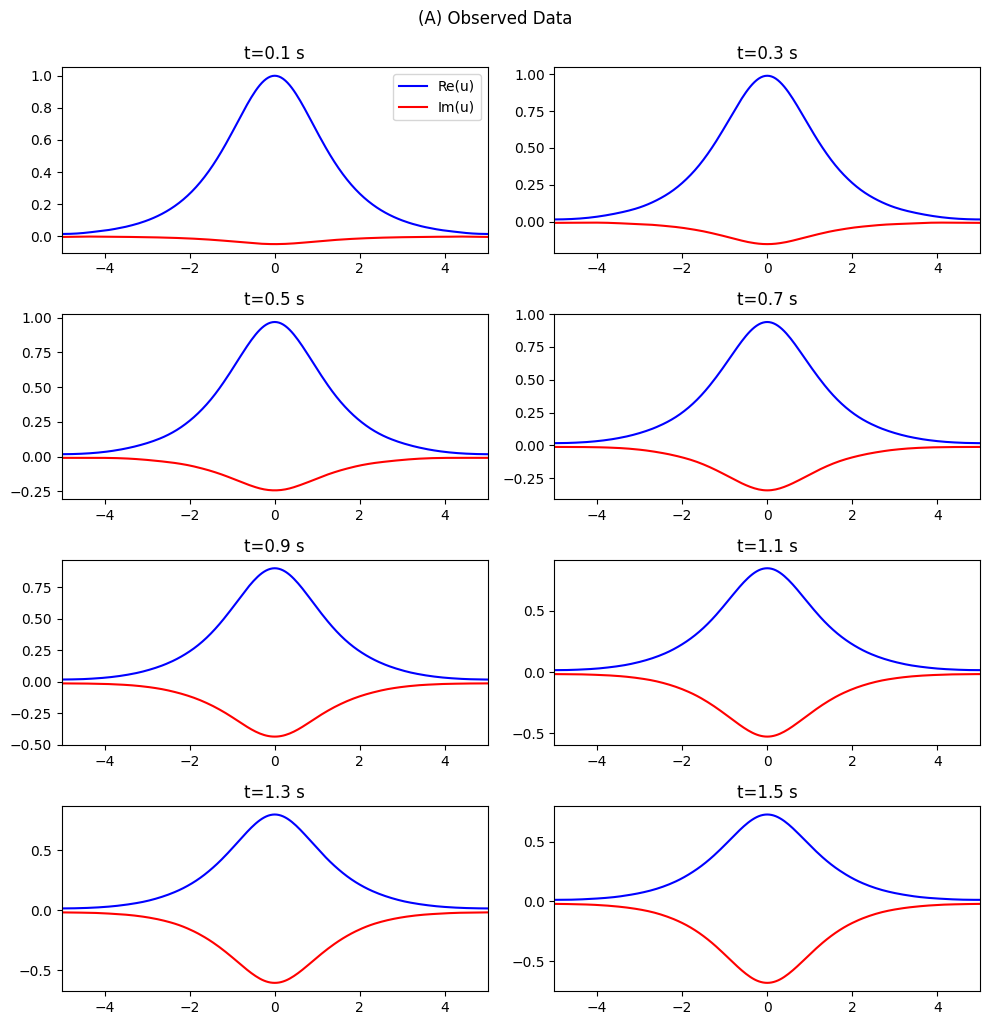

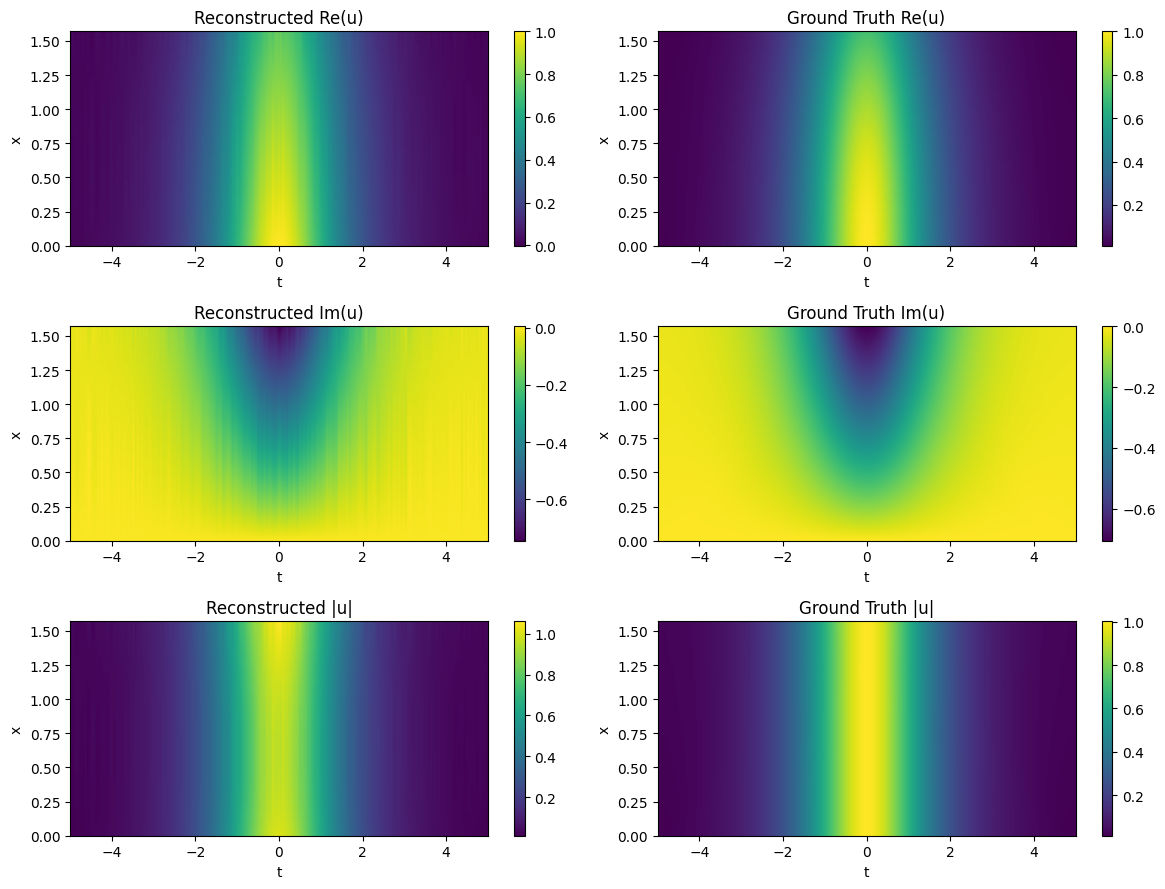

In [18]:
# 9. Plot observed snapshots at selected times
times_to_plot = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
ticks = [int(ti / float(T) * nt) for ti in times_to_plot]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(ticks):
    u_obs = sol_true[idx]
    re, im = u_obs[:N].cpu(), u_obs[N:].cpu()
    plt.subplot(4, 2, i+1)
    plt.plot(x.cpu(), re, 'b-', label='Re(u)' if i == 0 else "")
    plt.plot(x.cpu(), im, 'r-', label='Im(u)' if i == 0 else "")
    plt.title(f"t={times_to_plot[i]:.1f} s")
    plt.xlim(-5, 5)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.suptitle("(A) Observed Data", y=1.02)
plt.show()

# 10. Plot full space-time fields
fields = {
    "Re(u)": lambda u: u[:, :N],
    "Im(u)": lambda u: u[:, N:],
    "|u|": lambda u: torch.sqrt(u[:, :N]**2 + u[:, N:]**2)
}

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
for i, (name, fn) in enumerate(fields.items()):
    img1 = axs[i, 0].imshow(fn(pred_full).cpu(), extent=[-L, L, 0, float(T)], aspect='auto', origin='lower')
    axs[i, 0].set_title(f"Reconstructed {name}")
    fig.colorbar(img1, ax=axs[i, 0])

    img2 = axs[i, 1].imshow(fn(sol_true).cpu(), extent=[-L, L, 0, float(T)], aspect='auto', origin='lower')
    axs[i, 1].set_title(f"Ground Truth {name}")
    fig.colorbar(img2, ax=axs[i, 1])

    for ax in axs[i]:
        ax.set_ylabel("x")
        ax.set_xlabel("t")

plt.tight_layout()
plt.show()
